# Chapter 2. Probability and Statistical Inference: Homework

In [1]:
# Python built-in
from enum import Enum
from typing import Tuple, Optional, Union, Callable
# NumPy and Matplotlib
import numpy as np
from numpy.typing import ArrayLike
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Mitsuba
import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')   ## For Mac OS, comment out this line,
# mi.set_variant('llvm_ad_rgb') ## install LLVM through `brew install llvm`, and uncomment this line
# Helper functions for this lecture
from util import normalize, sph2vec, vec2sph, imshow_compare_many

-----
## Intro: Mini Path tracing

In [2]:
class PTSampleMode(Enum):
    LIGHT = 0
    BSDF = 1
    MIS = 2 # Multiple Importance Sampling

mis_weight = mi.ad.integrators.common.mis_weight # rename a mitsuba function

class MiniPTIntegrator(mi.ad.integrators.common.ADIntegrator):
    def __init__(self, sample_mode: PTSampleMode, props = mi.Properties()):
        super().__init__(props) # attributes `max_depth`, `rr_depth`

        assert isinstance(sample_mode, PTSampleMode)
        self.sample_mode = sample_mode

    def sample(self,
               mode: dr.ADMode,
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               active: mi.Bool,
               **kwargs # Absorbs unused arguments
               ):
        bsdf_ctx = mi.BSDFContext()
        L = mi.Spectrum(0)

        # ---------------------- Direct emission ----------------------
        si = scene.ray_intersect(ray,
                                 ray_flags=mi.RayFlags.All,
                                 coherent=True)
        L += si.emitter(scene).eval(si)

        # ------------------ Emitter sampling -------------------
        active_next = active & si.is_valid()
        # bsdf = si.bsdf(ray)
        bsdf = si.bsdf() # [SYYI] w/o the argument 'ray' seems okay if we do not need diff. rendering.

        if self.sample_mode in [PTSampleMode.LIGHT, PTSampleMode.MIS]:
            active_em = active_next & mi.has_flag(bsdf.flags(), mi.BSDFFlags.Smooth)
            ds, em_weight = scene.sample_emitter_direction(
                si, sampler.next_2d(), True, active_em)
            active_em &= dr.neq(ds.pdf, 0.0)

            wo = si.to_local(ds.d)
            bsdf_value_em, bsdf_pdf_em = bsdf.eval_pdf(bsdf_ctx, si, wo, active_em)
            if self.sample_mode != PTSampleMode.MIS:
                mis_em = 1.0
            else:
                mis_em = dr.select(ds.delta, 1.0, mi.ad.integrators.common.mis_weight(ds.pdf, bsdf_pdf_em))
            
            L += bsdf_value_em * em_weight * mis_em
        
        # ------------------ BSDF sampling -------------------
        if self.sample_mode in [PTSampleMode.BSDF, PTSampleMode.MIS]:
            # bsdf_sample, bsdf_weight = bsdf.eval_pdf_sample(bsdf_ctx, si, wo,
            #                                 sampler.next_1d(),
            #                                 sampler.next_2d(),
            #                                 active_next)
            bsdf_sample, bsdf_weight = bsdf.sample(bsdf_ctx, 
                                                   si,
                                                   sampler.next_1d(active_next),
                                                   sampler.next_2d(active_next),
                                                   active_next)
            ray_bsdf = si.spawn_ray(si.to_world(bsdf_sample.wo))
            active_bsdf = active_next & dr.any(dr.neq(bsdf_weight, 0.0))

            si_bsdf = scene.ray_intersect(ray_bsdf, active_bsdf)
            L_bsdf = si_bsdf.emitter(scene).eval(si_bsdf, active_bsdf)

            if self.sample_mode != PTSampleMode.MIS:
                mis_bsdf = 1.0
            else:
                ds = mi.DirectionSample3f(scene, si_bsdf, si)
                delta = mi.has_flag(bsdf_sample.sampled_type, mi.BSDFFlags.Delta)
                emitter_pdf = scene.pdf_emitter_direction(si, ds, active_bsdf & ~delta)
                mis_bsdf = mi.ad.integrators.common.mis_weight(bsdf_sample.pdf, emitter_pdf)
            
            L += L_bsdf * bsdf_weight * mis_bsdf

        return L, active_next, [], None

mi.register_integrator("mpath", lambda props: MiniPTIntegrator(props))


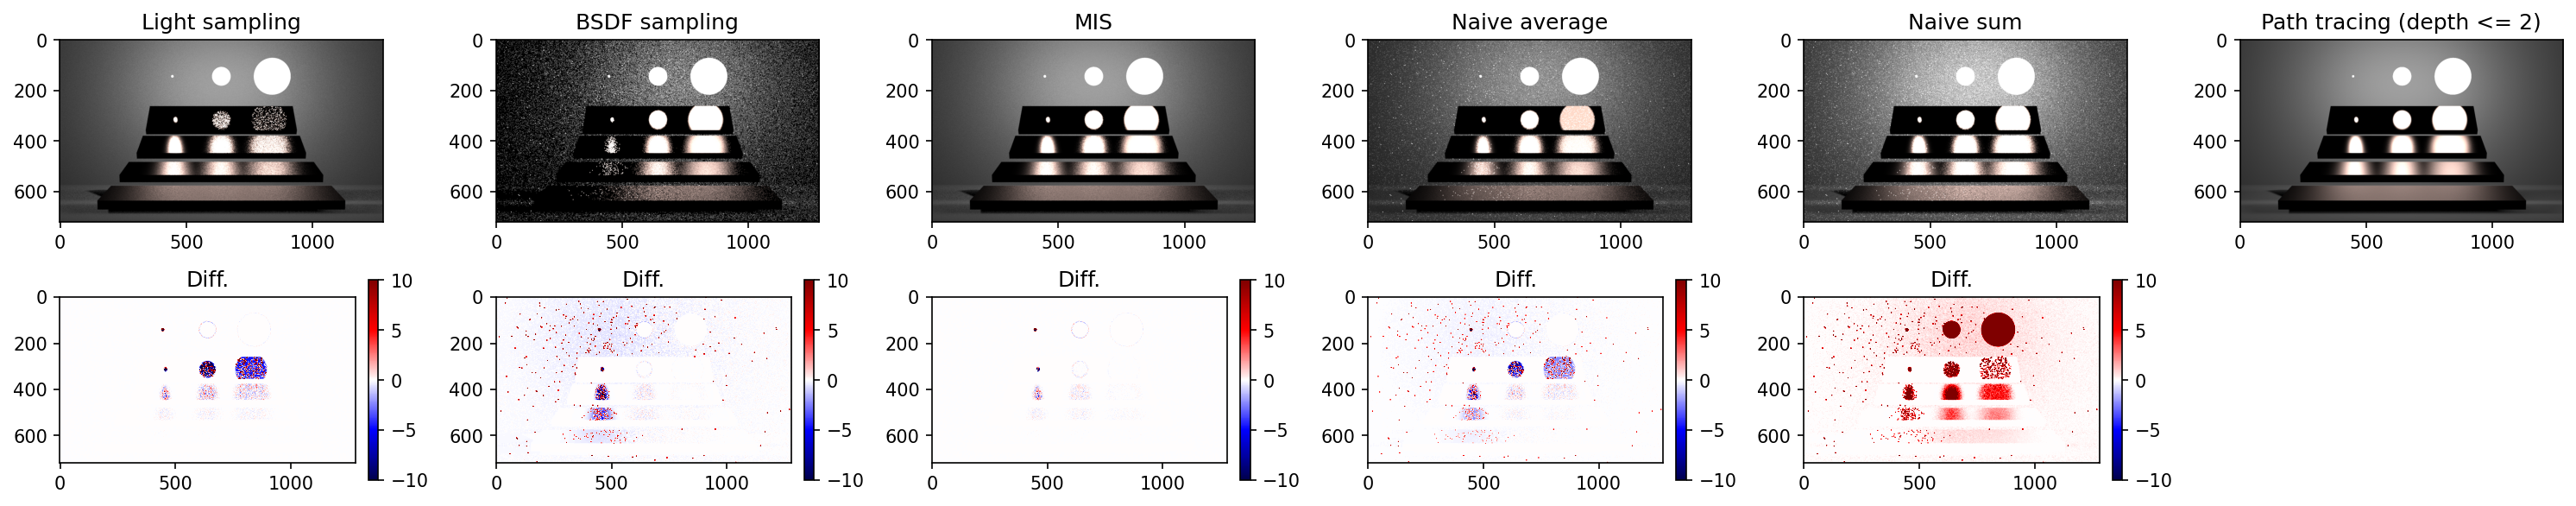

In [3]:
%matplotlib inline
spp = 16
pint_light = MiniPTIntegrator(PTSampleMode.LIGHT)
pint_bsdf = MiniPTIntegrator(PTSampleMode.BSDF)
pint_mis = MiniPTIntegrator(PTSampleMode.MIS)

scene = mi.load_file("./scene/veach-mis/scene.xml")
img_light = mi.render(scene, integrator=pint_light, spp=spp)
img_bsdf = mi.render(scene, integrator=pint_bsdf, spp=spp)
img_mis = mi.render(scene, integrator=pint_mis, spp=spp)
img_avg = (img_light + img_bsdf) / 2
img_sum = img_light + img_bsdf
# mi.Bitmap(img)
# plt.imshow(img**(1/2.2));

plt.figure(figsize=(20, 4), dpi=150)
imshow_compare_many([img_light, img_bsdf, img_mis, img_avg, img_sum], "figsrc/veachmis_max2_spp1024.exr",
                          ["Light sampling", "BSDF sampling", "MIS", "Naive average", "Naive sum"], "Path tracing (depth <= 2)",
                          vabs=10)

See "Naive sum" is the only *biased* estimator, and others are *unbiased*. However, "MIS" has the least variance ($\approx$ smallest noise).
Although "MIS" and "Naive average" require almost same computation cost, "MIS" outperforms than "Naive average".

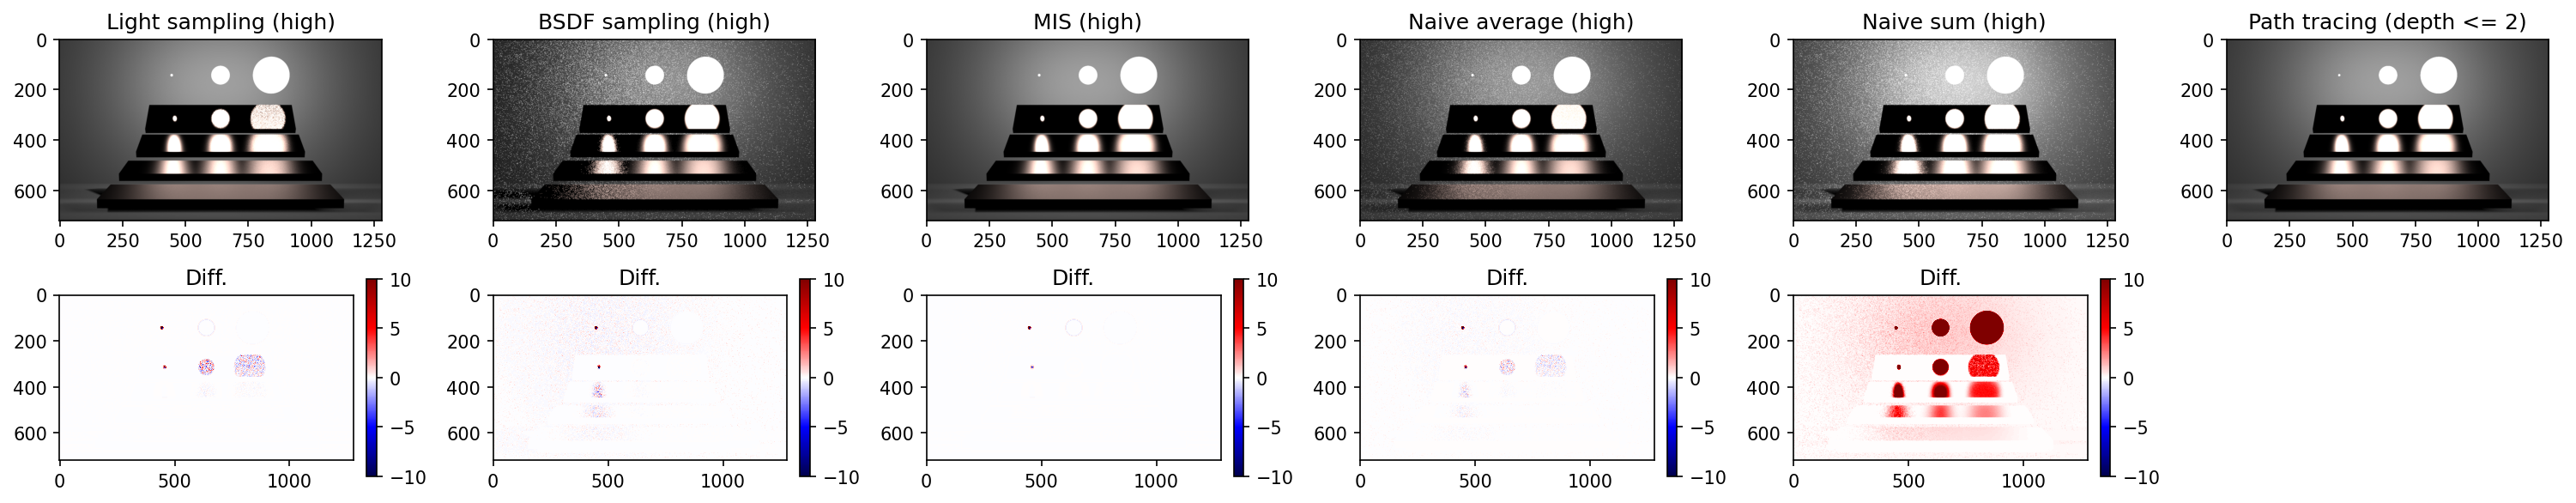

In [4]:
%matplotlib inline
spp_high = 1024
img_light_high = mi.render(scene, integrator=pint_light, spp=spp_high)
img_bsdf_high = mi.render(scene, integrator=pint_bsdf, spp=spp_high)
img_mis_high = mi.render(scene, integrator=pint_mis, spp=spp_high)
img_avg_high = (img_light_high + img_bsdf_high) / 2
img_sum_high = img_light_high + img_bsdf_high
# mi.Bitmap(img)
# plt.imshow(img**(1/2.2));

plt.figure(figsize=(20, 4), dpi=150)
imshow_compare_many([img_light_high, img_bsdf_high, img_mis_high, img_avg_high, img_sum_high], "figsrc/veachmis_max2_spp1024.exr",
                          ["Light sampling (high)", "BSDF sampling (high)", "MIS (high)", "Naive average (high)", "Naive sum (high)"], "Path tracing (depth <= 2)",
                          vabs=10)
plt.tight_layout()

-----
## Problem 1. Change of variables for PDFs
**Description.**
The function `visualize_pdf1d` in the following code block visualizes random samples given in the parameter `samples` and their histogram-based PDF (related to configuration parameter `bins`). It also compares given `samples` with an parameter of symbolinc function `answer`.

In [5]:
%matplotlib qt
# Matplotlib plots in external windows for progressive animation.

def visualize_pdf1d(samples:       ArrayLike, # [N]
                    bins:          int,
                    n_frame:       Optional[int] = 30,
                    n_max_scatter: Optional[int] = 300,
                    rv_label:      Optional[str] = "X",
                    answer:        Optional[Callable] = None):
    samples = np.asarray(samples)
    assert samples.ndim == 1
    N = samples.size
    N_range = np.floor(np.arange(n_frame) * N / n_frame).astype(np.int32)
    N_range[-1] = N
    fig = plt.figure(num="Numerically simulated PDF using a histogram")
    ax = fig.add_subplot(111)
    if answer is not None:
        assert callable(answer)
        gt_x = np.linspace(1e-2, 1, 100)
        gt_y = np.vectorize(answer)(gt_x)
    for n in N_range:
        n_scatter = min(n_max_scatter, n)
        ax.clear()
        ax.hist(samples[:n], bins=bins, density=True, label="simulated PDF")
        ax.scatter(samples[:n_scatter], np.full(n_scatter, 0.1), color='red', alpha=0.25, s=3.0, label="observations (samples)")
        if answer is not None:
            ax.plot(gt_x, gt_y, label="my answer for PDF")
        ax.set_title(f"N={n}")
        ax.set_xlabel(f"observation of r.v. ${rv_label}$")
        ax.set_ylabel(f"PDF $p_{rv_label}$")
        ax.legend()
        plt.pause(0.1)

# ---------- Test with unifrom distribution ----------
N = 20000
X = np.random.rand(N)
visualize_pdf1d(X, 10, rv_label="X", answer=lambda x:1);

c:\Users\class\.conda\envs\milecture\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


**(a)** Let $X\sim \mathcal U\left(\left[0,1\right]\right)$, where $\mathcal U\left(A\right)$ denotes the uniform distribution on $A\subset \mathbb{R}^n$. Find PDF of a r.v. $Y\coloneqq f\left(X\right)$ where $f\left(x\right)=x^2$

**Answer:** *Your answer here.*

In [6]:
""" Your code here """
answer = lambda y: 0
""" Your code end """

Y = X**2
visualize_pdf1d(Y, 10, rv_label="Y", answer=answer)

**(b)** In general, suppose there are a random variable $X\colon\Omega \to \mathbb R^n$ and a injective function $f\colon \mathbb R^n \to \mathbb R^m$, where $n\le m$. Denote $Y=f\left(X\right)$. Write the PDF of $Y$, $p_Y\left(y\right)$, using the PDF of $X$, $p_X\left(x\right)$.

(You can assume appropriate continuity conditions for $p_X$ and $f$ if you want.)



**Answer:** *Your answer here.*

**Description.** The following function `visualize_pdf2d` performs visualization of 2D random samples in a similar manner to `visualize_pdf1d`. You can run the following example code block of a 2D uniform random variable.

In [7]:
def visualize_pdf2d(samples:       ArrayLike, # xy[N, 2]
                    bins:          int,
                    n_frame:       Optional[int] = 30,
                    n_max_scatter: Optional[int] = 10000,
                    rv_label:      Optional[str] = "X",
                    answer:        Optional[Callable] = None): # answer(x,y,z) -> pdf
    samples = np.asarray(samples)
    N = samples.shape[0]
    assert samples.shape == (N, 2)
    N_range = np.floor(np.arange(n_frame) * N / n_frame).astype(np.int32)
    N_range[-1] = N

    fig = plt.figure(num="Numerically simulated PDF using a histogram", figsize=(12, 4))
    if answer is None:
        ax = fig.add_subplot(111)
    else:
        assert callable(answer)
        ax = fig.add_subplot(1, 2, 1)
        ax_gt = fig.add_subplot(1, 2, 2)
        gt_y, gt_x = np.mgrid[1e-6:1:100j, 1e-6:1:100j]
        gt_y = gt_y[::-1,:]
        gt_p = np.vectorize(answer)(gt_x, gt_y)


    for i,n in enumerate(N_range):
        n_scatter = min(n_max_scatter, n)
        # plt.clf()
        # fig = plt.figure(num="Numerically simulated PDF using a histogram")
        # ax = fig.add_subplot(111)
        ax.clear()
        hist = ax.hist2d(*(samples[:n, :].T), bins=bins, density=True, vmin=0)
        vmin, vmax = hist[3].get_clim()
        if i == 0:
            cbar = fig.colorbar(hist[3], ax=ax)
        else:
            cbar = fig.colorbar(hist[3], cax = cbar.ax, ax=ax)
        cbar.set_label(f"PDF $p_{rv_label}$\n", rotation=270)

        ax.scatter(*(samples[:n_scatter, :].T), color='red', alpha=0.25, s=3.0)
        ax.set_title(f"N={n}")
        ax.set_xlabel(f"r.v. ${rv_label}_1$")
        ax.set_ylabel(f"r.v. ${rv_label}_2$")

        if answer is not None:
            ax_gt.clear()
            mat = ax_gt.matshow(gt_p, vmin=vmin, vmax=vmax)
            if i == 0:
                cbar_gt = fig.colorbar(mat, ax=ax_gt)
            else:
                cbar_gt = fig.colorbar(mat, cax=cbar_gt.ax, ax=ax_gt)
            ax_gt.set_title(f"My answer for PDF")
            ax_gt.set_axis_off()
        plt.pause(0.1)

# ---------- Test with unifrom distribution ----------
N = 300000
X = np.random.rand(N, 2)
visualize_pdf2d(X, 10, rv_label="X", answer=lambda x,y: 1);

c:\Users\class\.conda\envs\milecture\Lib\site-packages\numpy\lib\histograms.py:1067: RuntimeWarning: invalid value encountered in divide
  hist /= s


**(c)** Let $X\sim \mathcal U\left(\left[0,1\right]^2\right)$. Find the PDF of a r.v. $Y\coloneqq f\left(X\right)$ where $f\left(x\right)=\left(x_1^3, \sqrt{x_2}\right)$

**Answer:** *Your answer here.*

In [8]:
""" Your code here """
answer = lambda x,y: 0
""" Your code end """

Y = np.stack([X[:,0]**3, X[:,1]**(1/2)], axis=1)
visualize_pdf2d(Y, 10, rv_label="Y", answer=answer);

**Description.** The following function `visualize_pdfS2` performs visualization of random samples on the 2-sphere $\mathbb{S}^2\coloneqq\left\{\mathbf{x} \in \mathbb{R}^3\mid \left\|\mathbf x\right\| = 1\right\}$ in a similar manner to `visualize_pdf1d` and `visualize_pdf2d`. You can run the following example code block of a uniform random variable on $\mathbb S^2$.

In [9]:
def histogramS2(samples: ArrayLike, # [*,3] for Cartesian or [*,2] for spherical coordinates
                n_bin:   int,       # theta (zenith angle) and phi (azimuth angle) will be separated into `n_bin` and `2*n_bin` bins, resp.
               ) ->      Tuple[ArrayLike, ArrayLike, ArrayLike]:
    """
    This function returns histogram 'density' (PDF) rather than 'counts'.
    Returns:
        hist_pdf:    ArrayLike[n_bin, 2*n_bin]     per face
        sphere_grid: ArrayLike[3, n_bin+1, 2*n_bin+1]
                     first `3` for X|Y|Z, later `[n_bin+1, 2*n_bin+1]` for per vertex
    """
    match samples.shape:
        case (N,3):
            theta, phi = vec2sph(samples)
        case (N,2):
            theta, phi = samples.T
        case _:
            raise ValueError(f"`samples.shape` should be (N,2) or (N,3), but ({samples.shape}) has been given.")
    H, xed, yed = np.histogram2d(theta, phi, bins=(n_bin, n_bin*2), range=[[0, np.pi], [-np.pi, np.pi]])
    
    area = (np.cos(xed[:-1]) - np.cos(xed[1:]))[:,None] * (yed[1:] - yed[:-1])[None,:]
    hist_pdf = H / area / N
    theta_grid, phi_grid = np.meshgrid(xed, yed, indexing='ij')
    return hist_pdf, sph2vec(theta_grid, phi_grid, axis=0)

def visualize_pdfS2(samples: ArrayLike, # xyz[N, 3] | sph[N, 2]
                    n_bin:         int,      # [n_bin, 2*n_bin] bins in theta-phi
                    n_frame:       int = 30,
                    n_max_scatter: int = 10000,
                    rv_label:      str = "X",
                    answer:        Optional[Callable] = None):
    samples = np.asarray(samples)
    N = samples.shape[0]
    if samples.shape == (N, 2):
        XYZ = sph2vec(*samples.T)
        theta, phi = samples.T
    elif samples.shape == (N, 3):
        XYZ = samples
        theta, phi = vec2sph(XYZ)
    else:
        raise ValueError(f"`samples.shape` should be (N,2) or (N,3), but {samples.shape} has been given.")
    
    N_range = np.floor(np.arange(n_frame) * N / n_frame).astype(np.int32)
    N_range[-1] = N

    fig = plt.figure(num="Numerically simulated PDF using a histogram", figsize=(12,6), dpi=150)
    if answer is None:
        ax = fig.add_subplot(111, projection='3d')
    else:
        assert callable(answer)
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        # ---------- Your answer for PDF ----------
        ax_gt = fig.add_subplot(1, 2, 2, projection='3d')
        ax_gt.set_aspect('equal', 'box')
        th_gt, ph_gt = np.mgrid[0:np.pi:201j, -np.pi:np.pi:401j] # Both vertices and face centers
        th_gtv, ph_gtv = th_gt[::2, ::2], ph_gt[::2,::2]
        th_gtf, ph_gtf = th_gt[1::2, 1::2], ph_gt[1::2, 1::2]
        pdf_val = np.vectorize(answer)(*sph2vec(th_gtf, ph_gtf, axis=0))

        sp_gt = ax_gt.plot_surface(*sph2vec(th_gtv, ph_gtv, axis=0), facecolors=cm.viridis(pdf_val))
        ax_gt.set_title("My answer for PDF")
        fig.colorbar(sp_gt, ax=ax_gt)
    # ---------- Scatter plot ----------
    ax.set_aspect('equal', 'box')
    ax.scatter(*(XYZ.T*1.02), s=0.3, color='red', alpha=0.25)
    ax.set_title("r.v. $X$")

    # ---------- Histogram PDF ----------
    hist_pdf, sphere_grid = histogramS2(np.stack([theta, phi], axis=-1), n_bin)
    sp = ax.plot_surface(*sphere_grid, cstride=1, rstride=1, facecolors=cm.viridis( hist_pdf))
    fig.colorbar(sp, ax=ax)

N = 10000
X = normalize(2*np.random.rand(10000, 3) - 1)
visualize_pdfS2(X, 8, rv_label="X", answer=lambda x,y,z: 1/4/np.pi)

**(d)** The above implementation of uniform variable on $\mathbb S^2$ has problems: too many (three per sample) random numbers are required and numerically unstable. Using a 2D uniform random variable $X\sim \mathcal U\left(\left[0,1\right]^2\right)$, find a function $f:\left[0,1\right]^2 \to \mathbb S^2$ such that $Y\coloneqq f\left(X\right)$ has a unifrom distribution on $\mathbb S^2$.

(Hint: tranform $X_1$ to some function of $\theta$ and $X_2$ to $\phi$ in polar coordinates)

In [10]:
""" Your answer here """
f = lambda u,v: (u/np.sqrt(u*u+v*v), v/np.sqrt(u*u+v*v), np.zeros_like(u))
""" Your answer end """

X = np.random.rand(N, 2)
Y = np.stack(f(X[:,0], X[:,1]), axis=-1)
visualize_pdfS2(Y, 8, rv_label="X", answer=lambda x,y,z: 1/4/np.pi)

-----

## Problem 2. Monte Carlo Integration

**Description.** The Monte Carlo integration is stated as follows.
> **Proposition.** *(Monte Carlo integration)*
> 
> There is a function $f:D\subset \mathbb R^n \to \mathbb R$ and its integration problem $I = \int_D {f\left(x\right)\mathrm d x}$. Suppose there is a random variable $X:\Omega \to D$. The following is an unbiased estimator of $I$,
> $$
> \hat I = \frac 1 N \sum_{i=1}^N\frac{f\left(X_i\right)}{p_X\left(X_i\right)}
> $$
> if $\forall x\in D,\ p_X\left(x\right) = 0 \Rightarrow f\left(x\right)=0$. Here, $X_i$ is $N$ i.i.d. random variables for $X$.

Note that unbiased indicates $\mathbb E\left[\hat I\right] = I$.

The following code block shows a Monte Carlo integration process for a problem:
$$
I=\int_0^5{f\left(x\right)\mathrm d x}, \text{ where }f\left(x\right)=\sqrt{x},
$$
with a uniform random variable $X\sim \mathcal U\left(\left[0,5\right]\right)$.

In the function `visualize_MC1d`, arguments should satisfy an important contraint: random numbers `samples=X` should be generated under the PDF `pdf=pdf`. If these two arguments are inconsistent (if you missed to evaluated the PDF), you will get a biased (incorrect) estimator. Try to change one of line `X = U*5` or `pdf = lambda x: 1/5` to any other and check the results become wrong.

In [11]:
def visualize_MC1d(samples:       ArrayLike, # [N]
                   func:          Callable,
                   pdf:           Callable,
                   bounds:        Tuple[float, float] = [0,1],
                   int_gt:        Optional[float] = None,
                   n_frame:       Optional[int] = 30,
                   n_max_scatter: Optional[int] = 300
                  ):
    samples = np.asarray(samples)
    assert samples.ndim == 1
    N = samples.size
    N_range = np.floor(np.arange(1, n_frame) * N / n_frame).astype(np.int32)
    N_range[-1] = N
    fig = plt.figure(num="1D Monte Carlo integration")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x_lin = np.linspace(bounds[0], bounds[1], 100)
    y_lin = np.vectorize(func)(x_lin)
    if int_gt is not None:
        gt_lin = np.full_like(x_lin, int_gt)

    f_samples = np.vectorize(func)(samples)
    pdf_samples = np.vectorize(pdf)(samples)
    weight_samples = f_samples / pdf_samples

    for n in N_range:
        n_scatter = min(n_max_scatter, n)
        ax1.clear()
        ax2.clear()

        ax1.scatter(samples[:n], f_samples[:n], color='red', alpha=0.5, s=4.0, label=r"observations $f\left(X\right)$")
        ax1.plot(x_lin, y_lin, label="subject function $f$")
        ax1.set_title(f"N={n}")
        ax1.set_xlabel(f"domain $x$")
        ax1.set_ylabel(r"$f\left(x\right)$")
        ax1.legend()
        
        current_integral = weight_samples[:n].mean()
        current_sigma = np.std(weight_samples[:n], ddof=1)
        ax2.scatter(samples[:n], weight_samples[:n], color='red', alpha=0.5, s=4.0, label=r"observations $\frac{f\left(X\right)}{p_X\left(X\right)}$")
        ax2.plot(x_lin, np.full_like(x_lin, current_integral), color='red', label=r"MC estimate $\hat I$")
        if int_gt is None:
            ax2.set_title(R"$\hat{I}=" + f"{current_integral:.4f}$")
        else:
            ax2.set_title(R"$\hat{I}=" + f"{current_integral:.4f}, " + R"\hat{\sigma}=" + f"{current_sigma:.4f}$")
            ax2.plot(x_lin, gt_lin, label=r"GT $I$" + f" (={int_gt:.4f})")
        ax2.set_xlabel(f"domain $x$")
        ax2.set_ylabel(R"$\frac{f\left(x\right)}{p\left(x\right)}$")
        ax2.legend()
        fig.tight_layout()
        plt.pause(0.1)

# ---------- Test with unifrom distribution ----------
N = 500
U = np.random.rand(N)
X = U*5
f = lambda x: np.sqrt(x)
pdf = lambda x: 1/5
int_gt = 2/3*(5**(3/2))
visualize_MC1d(X, f, pdf, [0, 5], int_gt=int_gt)

### Importance sampling
The performance of a Monte Carlo integration can be understood as the amount of the *variance* of the estimator. The variance is highly depends on *which distribution* (PDF) of $X$ we use. See the following property.
> **Proposition.** *(Variance of Monte Carlo integration)*
> 
> The variance of a Monte Carlo estimator $\hat I = \frac 1 N \sum_{i=1}^N \frac{f\left(X_i\right)}{p_X\left(X_i\right)}$ is evaluated as follows.
> $$
> V\left[\hat I\right] = \frac 1N \left(\int_D{ \frac{f\left(x\right)^2}{p_X\left(x\right)} \mathrm d x } - I^2\right)
> $$
> 

We first observe that the variance is proportional to inverse of $N$ independent of dimension of the domain $D$. However, error for integration by regular grid is proportional to $N^{-1/\mathrm{dim}D}$ (for quadrature rule), which becomes highly inefficient in higher dimensions.

Next, we observe that another fact from the above proposition. If we have $p_X \propto f$, i.e., $p_X\left(x\right)=\frac{f\left(x\right)}{I}$ (the denominator $I$ comes from the property that integrating PDFs should be $1$.), the variance become zero. Variances should be nonnegative, the zero is the minimum value. One may feel weird for this situation that a *probabilistic* estimator yields a *zero* variance. The reason is that sampling a random variable with a PDF $\propto f$ is equally hard to or harder than knowing the analytic integral of $f$.

**(a)** Using the same definitions of $f$ and $I$ in the previous code block, find a random variable $X$ whose pdf satisfies $p_X \propto f$

**Answer:** *Your answer here.*

In [12]:
""" Your answer here """
X = 5*U
pdf = lambda x: 1 / 5
# pdf = lambda x: np.sqrt(x) / int_gt
""" Your answer end """

visualize_MC1d(X, f, pdf, [0, 5], int_gt=int_gt)

**(b)** In the above problem **(a)**, we saw that generating a random variable with a PDF $\propto f$ is harder than integrating $f$ itself. However, importance sampling technique is still useful when the integrand $f$ is too hard but we know an easier proxy of $f$. We observe that the integrand $f\left(x\right)=\sqrt{x}$ is increasing, and guess that transforming `X=5*np.sqrt(U)` would yield similar PDF to $f$. Find the PDF of the variable `X` in the following code block and check its MC integration results yield a less variance than that with uniform distribution, which we saw in the first code block for `visualize_MC1d`.

**Answer:** *Your answer here.*

In [13]:
""" Your answer here """
pdf = lambda x: 1
""" Your answer end """

X = 5*(np.sqrt(U))
visualize_MC1d(X, f, pdf, [0, 5], int_gt=int_gt)